# https://archive.ics.uci.edu/dataset/45/heart+disease

In [2]:
from pyspark.sql import SparkSession
import pyspark
import findspark


findspark.init()

In [3]:
from pyspark.sql.types import (IntegerType, FloatType,
                               StructField, StructType)

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/07 06:13:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [4]:
df = spark.read.format("csv").option("path", "data/heart.csv").option("header", True) \
    .schema(StructType([
            StructField("age", IntegerType()),
            StructField("sex", IntegerType()),
            StructField("cp", IntegerType()),
            StructField("trtbps", IntegerType()),
            StructField("chol", IntegerType()),
            StructField("fbs", IntegerType()),
            StructField("restecg", IntegerType()),
            StructField("thalachh", IntegerType()),
            StructField("exng", IntegerType()),
            StructField("oldpeak", FloatType()),
            StructField("slp", IntegerType()),
            StructField("caa", IntegerType()),
            StructField("thall", IntegerType()),
            StructField("output", IntegerType()),
    ])).load()

df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trtbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalachh: integer (nullable = true)
 |-- exng: integer (nullable = true)
 |-- oldpeak: float (nullable = true)
 |-- slp: integer (nullable = true)
 |-- caa: integer (nullable = true)
 |-- thall: integer (nullable = true)
 |-- output: integer (nullable = true)



In [5]:
df.show()

+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
|age|sex| cp|trtbps|chol|fbs|restecg|thalachh|exng|oldpeak|slp|caa|thall|output|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
| 63|  1|  3|   145| 233|  1|      0|     150|   0|    2.3|  0|  0|    1|     1|
| 37|  1|  2|   130| 250|  0|      1|     187|   0|    3.5|  0|  0|    2|     1|
| 41|  0|  1|   130| 204|  0|      0|     172|   0|    1.4|  2|  0|    2|     1|
| 56|  1|  1|   120| 236|  0|      1|     178|   0|    0.8|  2|  0|    2|     1|
| 57|  0|  0|   120| 354|  0|      1|     163|   1|    0.6|  2|  0|    2|     1|
| 57|  1|  0|   140| 192|  0|      1|     148|   0|    0.4|  1|  0|    1|     1|
| 56|  0|  1|   140| 294|  0|      0|     153|   0|    1.3|  1|  0|    2|     1|
| 44|  1|  1|   120| 263|  0|      1|     173|   0|    0.0|  2|  0|    3|     1|
| 52|  1|  2|   172| 199|  1|      1|     162|   0|    0.5|  2|  0|    3|     1|
| 57|  1|  2|   150| 168|  0

In [6]:
def show_summary_statistics(df):
    for column in df.columns:
        print(f"Summary statistics for column: {column}")
        df.select(column).summary().show(truncate=False)

In [7]:
show_summary_statistics(df)

Summary statistics for column: age
+-------+------------------+
|summary|age               |
+-------+------------------+
|count  |303               |
|mean   |54.366336633663366|
|stddev |9.08210098983786  |
|min    |29                |
|25%    |47                |
|50%    |55                |
|75%    |61                |
|max    |77                |
+-------+------------------+

Summary statistics for column: sex
+-------+-------------------+
|summary|sex                |
+-------+-------------------+
|count  |303                |
|mean   |0.6831683168316832 |
|stddev |0.46601082333962385|
|min    |0                  |
|25%    |0                  |
|50%    |1                  |
|75%    |1                  |
|max    |1                  |
+-------+-------------------+

Summary statistics for column: cp
+-------+------------------+
|summary|cp                |
+-------+------------------+
|count  |303               |
|mean   |0.966996699669967 |
|stddev |1.0320524894832983|
|min    |0  

In [8]:
import matplotlib.pyplot as plt

def plot_histogram(df, numeric_column, bins=None):
    if bins is None:
        unique_values = df.select(numeric_column).distinct().count()
        bins = min(unique_values, 10)  # You can adjust the maximum number of bins (e.g., 10)

    hist_bins, hist_counts = df.select(numeric_column).rdd.flatMap(lambda x: x).histogram(bins)

    # Plot the histogram using matplotlib
    plt.bar(hist_bins[:-1], hist_counts, width=hist_bins[1] - hist_bins[0])
    plt.xlabel(numeric_column)
    plt.ylabel("Frequency")
    plt.title("Histogram of " + numeric_column)
    plt.show()


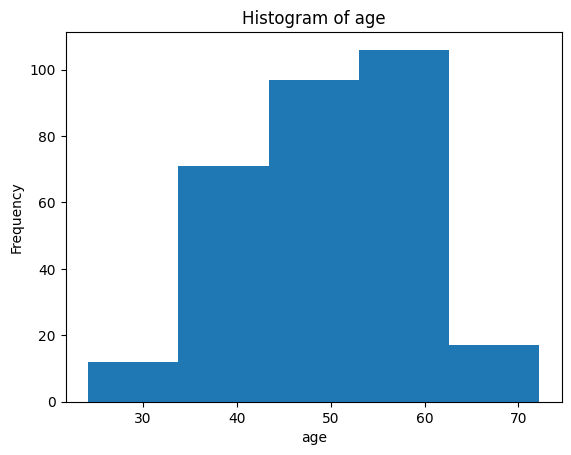

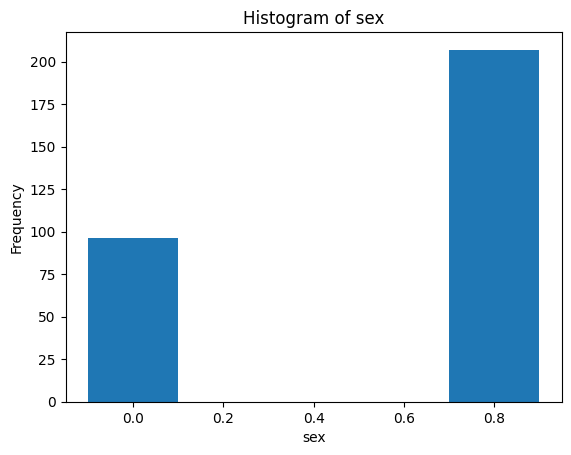

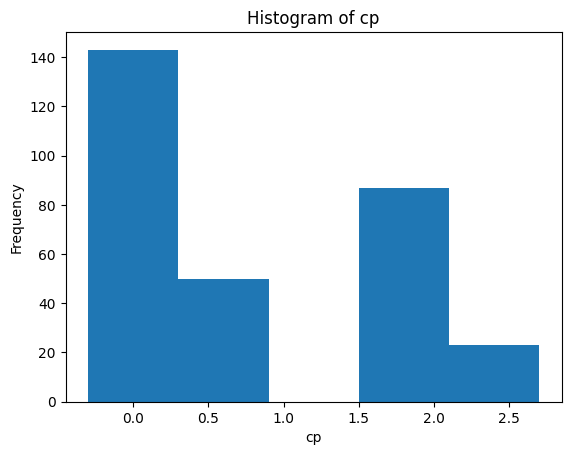

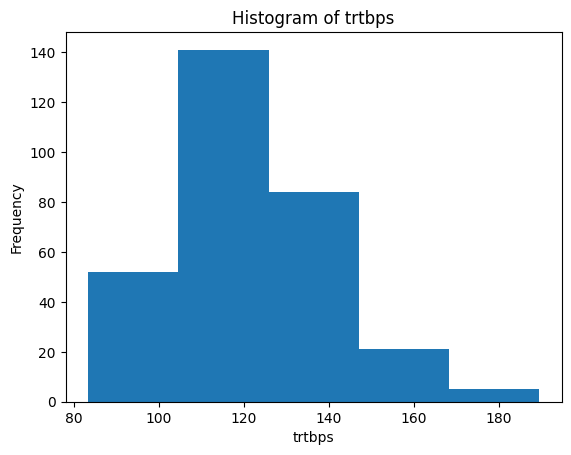

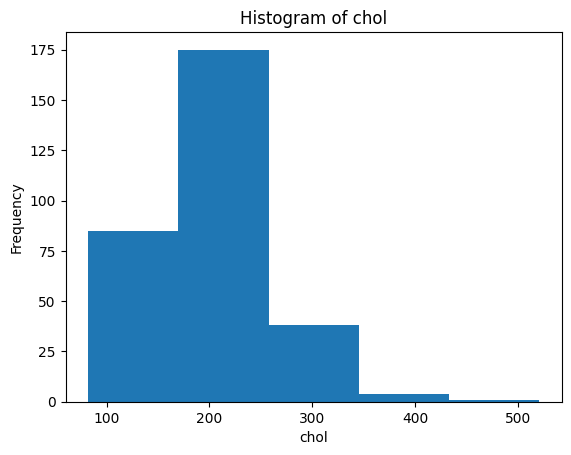

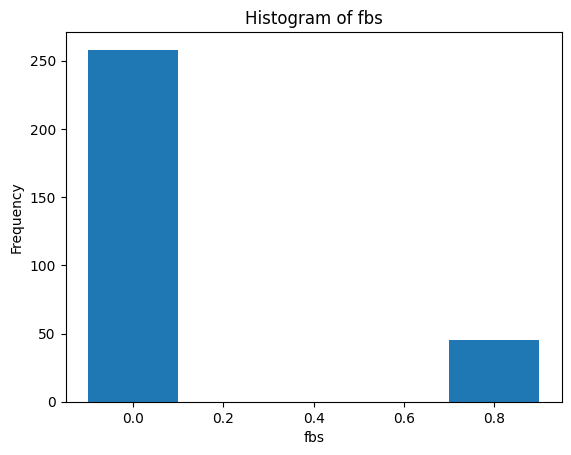

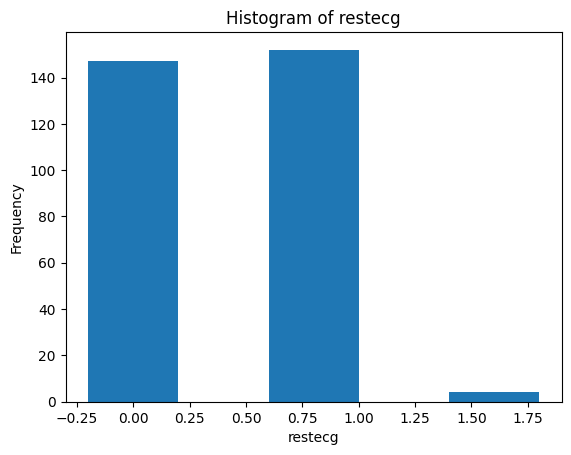

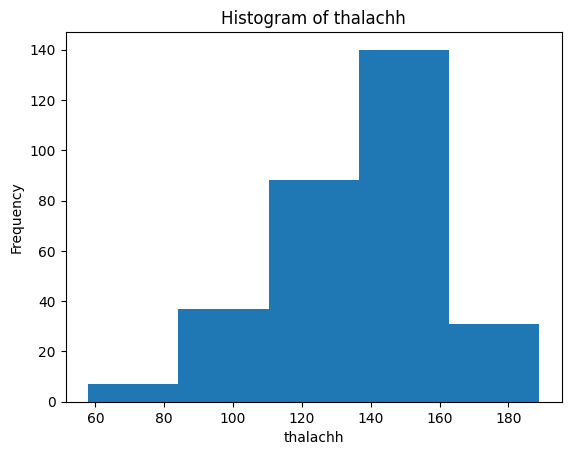

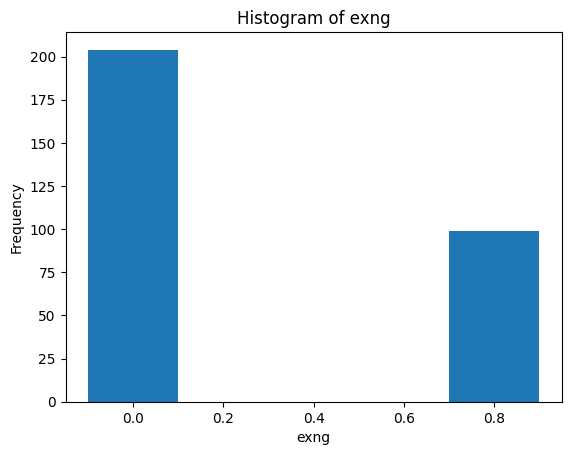

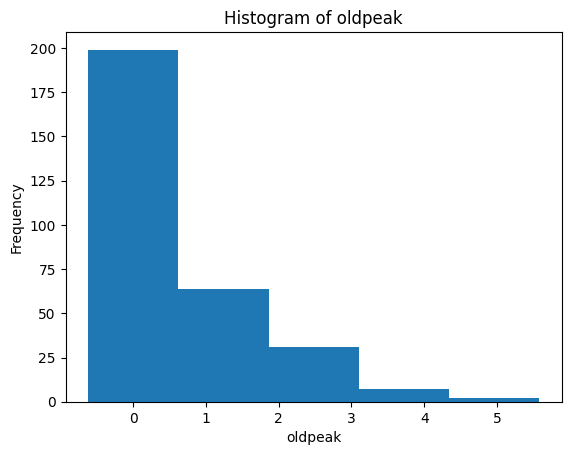

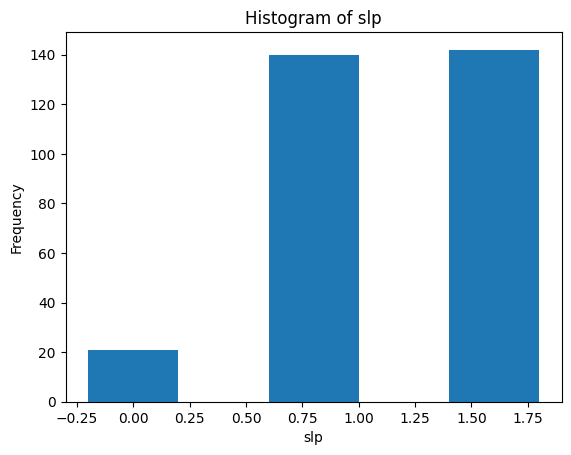

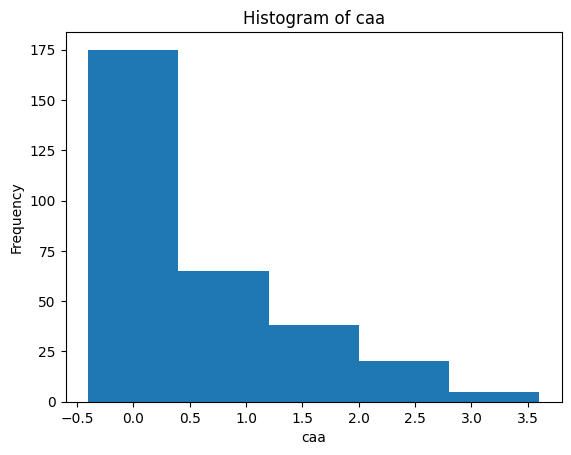

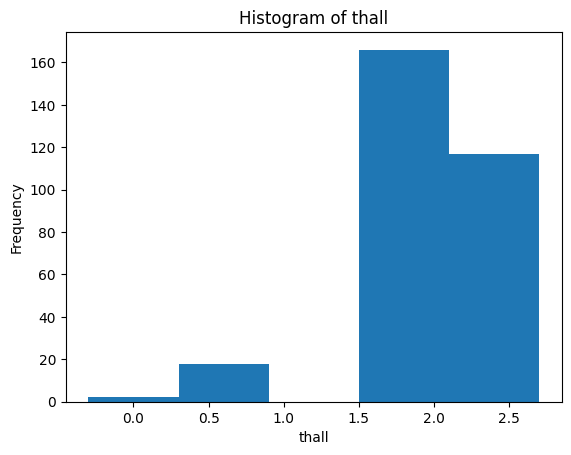

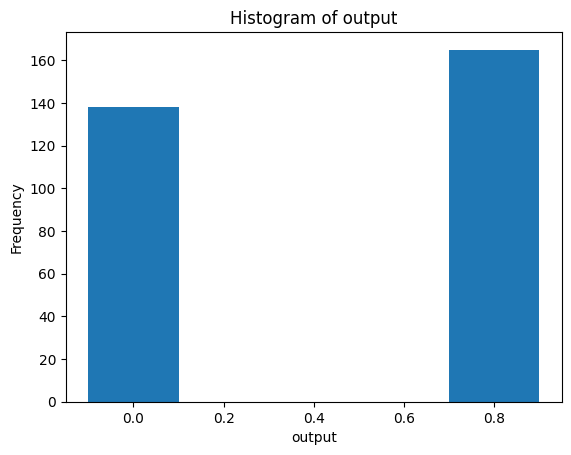

In [9]:
numeric_columns = [col for col in df.columns if df.schema[col].dataType != 'string']


for column in numeric_columns:
    plot_histogram(df, column, bins=5)

In [10]:
def plot_boxplot(df, numeric_column):

    column_data = df.select(numeric_column).rdd.flatMap(lambda x: x).collect()

    # Plot the boxplot using matplotlib
    plt.boxplot(column_data)
    plt.xlabel(numeric_column)
    plt.ylabel("Values")
    plt.title("Boxplot of " + numeric_column)
    plt.show()

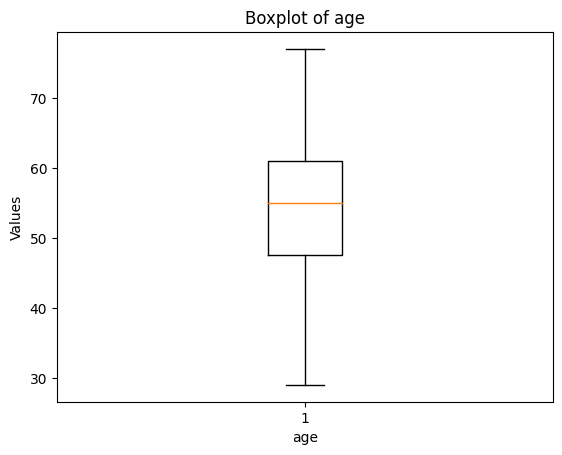

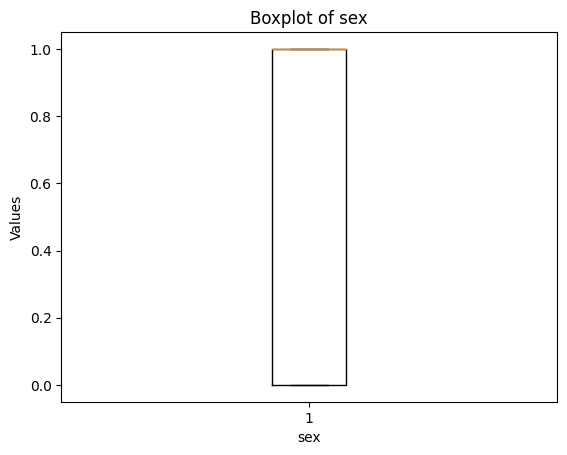

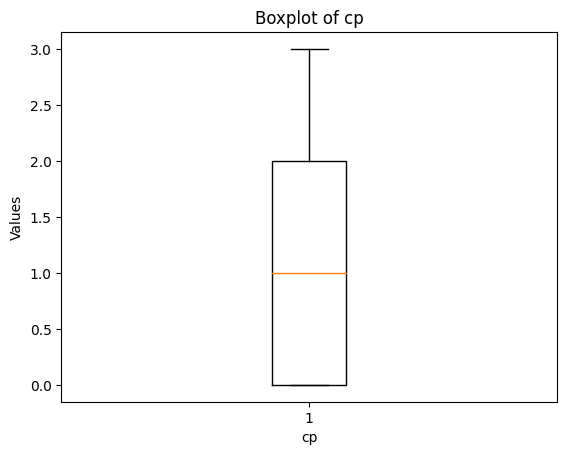

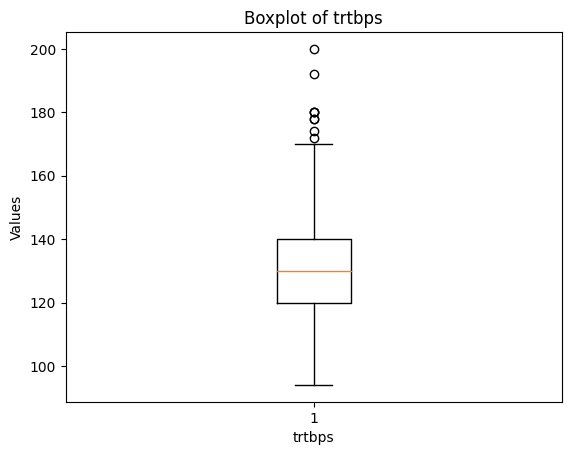

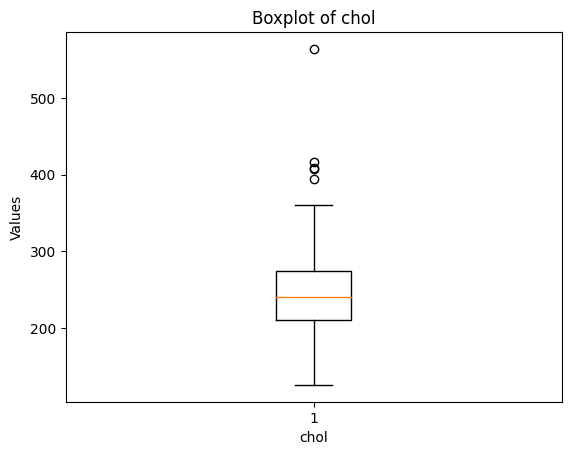

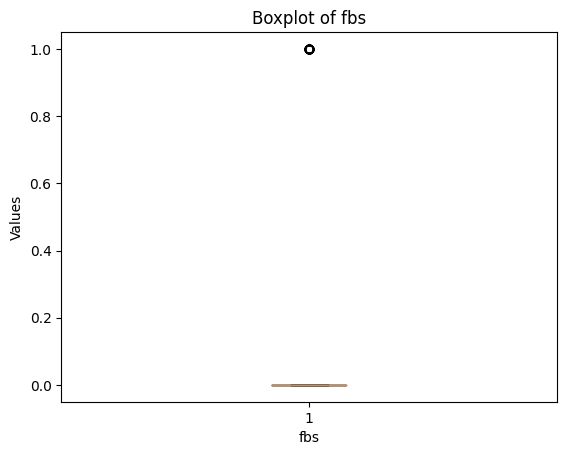

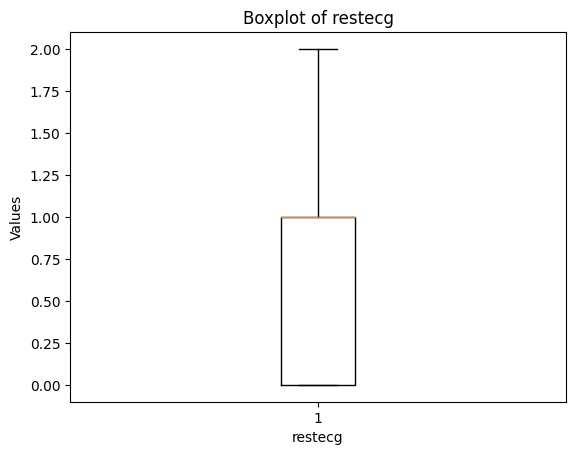

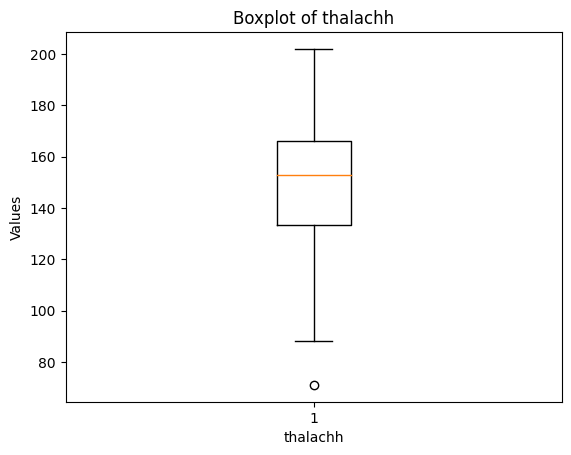

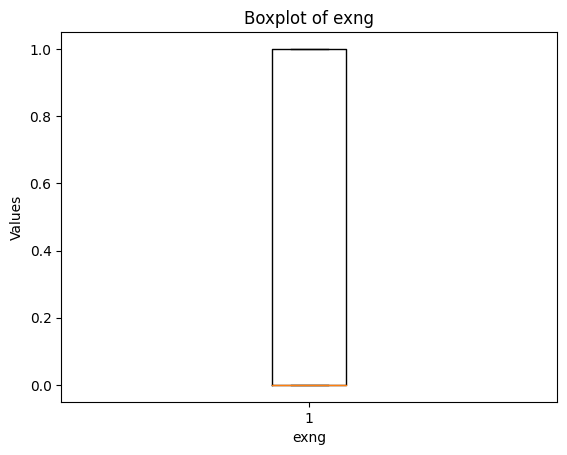

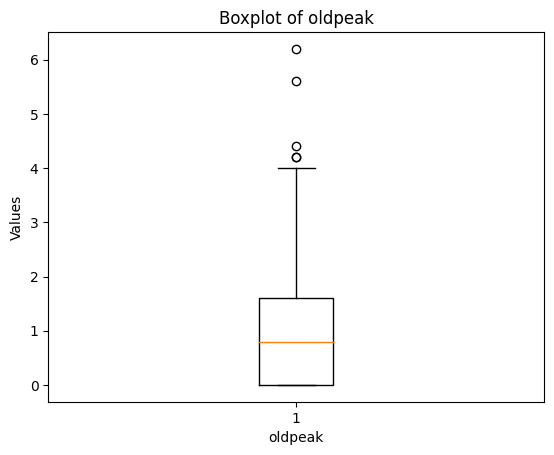

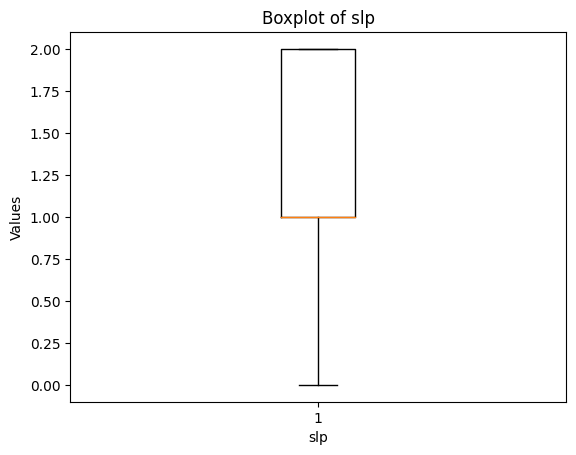

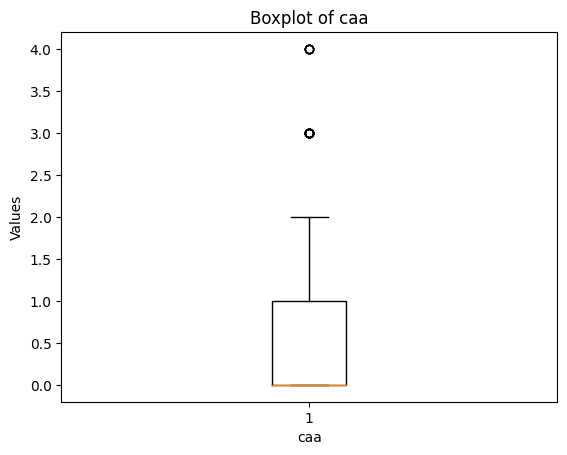

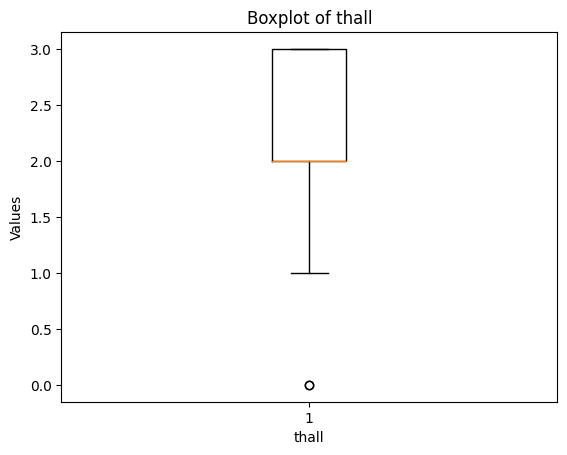

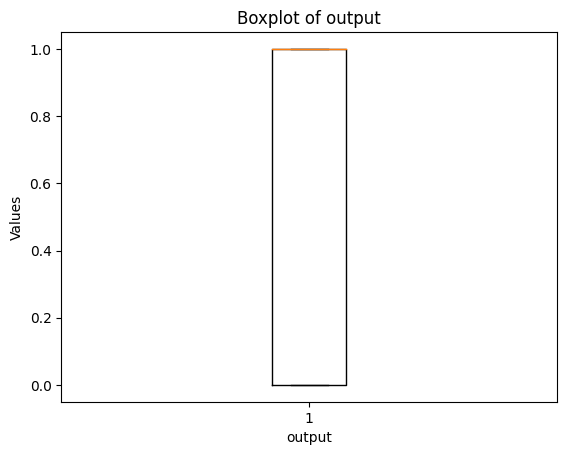

In [11]:
numeric_columns = [col for col in df.columns if df.schema[col].dataType != 'string']


for column in numeric_columns:
    plot_boxplot(df, column)

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

def plot_correlation_heatmap(df, figsize=(10, 8)):
    numeric_columns = [col for col in df.columns if df.schema[col].dataType != 'string']

    vector_assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
    assembled_df = vector_assembler.transform(df).select("features")

    correlation_matrix = Correlation.corr(assembled_df, "features").collect()[0][0]
    correlation_matrix_np = np.array(correlation_matrix.toArray()) * 100  # Multiply by 100 for percentage
    mask = np.triu(np.ones_like(correlation_matrix_np, dtype=bool))

    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix_np, annot=True, fmt=".1f", mask=mask, cmap='coolwarm', xticklabels=numeric_columns, yticklabels=numeric_columns)

    plt.title("Correlation Heatmap")
    plt.show()

23/12/07 06:13:51 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


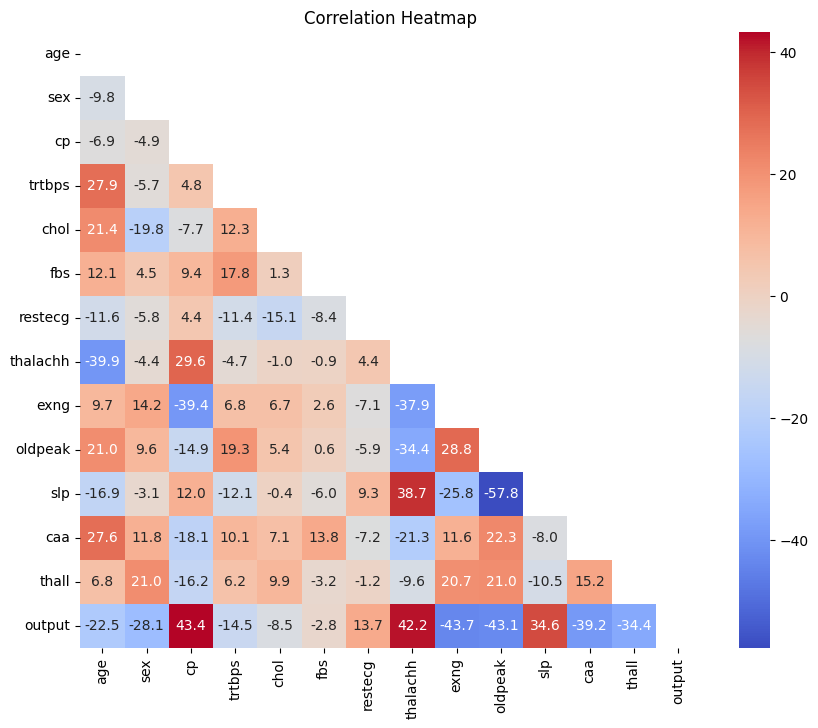

In [13]:
plot_correlation_heatmap(df)

In [14]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

unlist = udf(lambda x: round(float(list(x)[0]), 3), DoubleType())

# Iterating over columns to be scaled
for col_name in ["age", "cp", "trtbps", "chol", "thalachh", "oldpeak", "slp", "caa", "thall"]:
    assembler = VectorAssembler(inputCols=[col_name], outputCol=col_name + "_Vect")
    scaler = StandardScaler(inputCol=col_name + "_Vect", outputCol=col_name + "_Scaled")

    pipeline = Pipeline(stages=[assembler, scaler])
    df_scaled = pipeline.fit(df).transform(df).withColumn(col_name, unlist(col_name + "_Scaled")).drop(col_name + "_Vect", col_name + "_Scaled")

print("After Scaling:")
df_scaled.show(5)

After Scaling:


+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
|age|sex| cp|trtbps|chol|fbs|restecg|thalachh|exng|oldpeak|slp|caa|thall|output|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
| 63|  1|  3|   145| 233|  1|      0|     150|   0|    2.3|  0|  0|1.633|     1|
| 37|  1|  2|   130| 250|  0|      1|     187|   0|    3.5|  0|  0|3.266|     1|
| 41|  0|  1|   130| 204|  0|      0|     172|   0|    1.4|  2|  0|3.266|     1|
| 56|  1|  1|   120| 236|  0|      1|     178|   0|    0.8|  2|  0|3.266|     1|
| 57|  0|  0|   120| 354|  0|      1|     163|   1|    0.6|  2|  0|3.266|     1|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
only showing top 5 rows



In [15]:
show_summary_statistics(df_scaled)

Summary statistics for column: age
+-------+------------------+
|summary|age               |
+-------+------------------+
|count  |303               |
|mean   |54.366336633663366|
|stddev |9.08210098983786  |
|min    |29                |
|25%    |47                |
|50%    |55                |
|75%    |61                |
|max    |77                |
+-------+------------------+

Summary statistics for column: sex
+-------+-------------------+
|summary|sex                |
+-------+-------------------+
|count  |303                |
|mean   |0.6831683168316832 |
|stddev |0.46601082333962385|
|min    |0                  |
|25%    |0                  |
|50%    |1                  |
|75%    |1                  |
|max    |1                  |
+-------+-------------------+

Summary statistics for column: cp
+-------+------------------+
|summary|cp                |
+-------+------------------+
|count  |303               |
|mean   |0.966996699669967 |
|stddev |1.0320524894832983|
|min    |0  

In [19]:


df_scaled \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .save()

In [20]:
training = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .load()
training.show()

+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
|age|sex| cp|trtbps|chol|fbs|restecg|thalachh|exng|oldpeak|slp|caa|thall|output|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
| 63|  1|  3|   145| 233|  1|      0|     150|   0|    2.3|  0|  0|1.633|     1|
| 37|  1|  2|   130| 250|  0|      1|     187|   0|    3.5|  0|  0|3.266|     1|
| 41|  0|  1|   130| 204|  0|      0|     172|   0|    1.4|  2|  0|3.266|     1|
| 56|  1|  1|   120| 236|  0|      1|     178|   0|    0.8|  2|  0|3.266|     1|
| 57|  0|  0|   120| 354|  0|      1|     163|   1|    0.6|  2|  0|3.266|     1|
| 57|  1|  0|   140| 192|  0|      1|     148|   0|    0.4|  1|  0|1.633|     1|
| 56|  0|  1|   140| 294|  0|      0|     153|   0|    1.3|  1|  0|3.266|     1|
| 44|  1|  1|   120| 263|  0|      1|     173|   0|    0.0|  2|  0|  4.9|     1|
| 52|  1|  2|   172| 199|  1|      1|     162|   0|    0.5|  2|  0|  4.9|     1|
| 57|  1|  2|   150| 168|  0